In [2]:
import sqlite3
from sqlite3 import Error
import os.path
from os import path

from create_db import create_connection, create_table, clean_column_names
from populate_db import extract_data, insert_records
import query_db as qd
import config
import build_dataset as build
import pipeline
import classification

import importlib
import datetime
import re
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, cross_val_score, PredefinedSplit
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix, classification_report, plot_roc_curve, plot_precision_recall_curve 

# Decision Tree
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import ParameterGrid
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import ParameterGrid
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
%matplotlib inline


Bad key "text.kerning_factor" on line 4 in
/Users/daminisharma/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


# Notebook table of contents:
1. Run all models for binary outcome variable. Run the best model according to F1 score and precision, predict on test data, calculate evaluation metrics
2. Repeat 1 without using demographic features
3. Repeat 1-2 on three-class outcome variable
4. Repeat 1-2 on 6-class outcome variable

In [3]:
# Import data
dataset_3 = pd.read_csv('../data/dataset_main_active3.csv')

/Users/daminisharma/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (21,22,29,30,32) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [51]:
# Step 1
target_type = "binary"
features = "Demographics"

#print(features)
#train_data, test_data, validate_data, active_sentences = build.split_and_process(dataset_1,config,grouping_target)
train_data, test_data, validate_data, active_sentences, active_almost_complete = build.split_and_process(dataset_3,config,target_type,features)


# Sanity Check
print('Train and Test Check:')
build.sanity_check(train_data,test_data)

print('Train and Validate Check:')
build.sanity_check(train_data,validate_data)

print('Train and Active Check:')
build.sanity_check(train_data,active_sentences)

print('Train and Active Almost Complete Check:')
build.sanity_check(train_data,active_almost_complete)



248
Size of active sentences dataset:  32711
Dataset size:  773724


/Users/daminisharma/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/daminisharma/miniconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/Users/daminisharma/miniconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See th

Total Number of Unique IDs: 418845
Total Number of IDs in Test Data: 83769
Total Number of IDs in Train Data: 268061
Total Number of IDs in Validate Data: 67015
Do the IDs add up? True
Does Test Represent 20% of the data? True
Test Represents X% of the data: 0.2
Does Train+Validate Represent 80% of the data? False
Train+Validate Represents X% of the data: 0.8
Does Validate Represent 20% of the Train+Validate Data?: 0.19999940312048609
Does Train Represent 80% of the Train+Validate Data?: 0.8000005968795139


/Users/daminisharma/Dropbox/Harris MSCAPP/2019-20_Q3_Spring/Machine Learning/covid_decarceration/files/build_dataset.py:686: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_first_offense.drop_duplicates(inplace=True)


Index(['RACE', 'GENDER', 'ETHNICITY', 'CONTROL_STATUS', 'OFFENSE_CLEAN',
       'Current_Offense_Risk_Level', 'year_month', 'INFRACTION_PER_SENT',
       'misd_count', 'felon_count', 'sentence_count', 'age_at_sentence',
       'unemp_rate', 'ID', 'COMMITMENT_PREFIX', 'BIRTH_DATE',
       'EARLIEST_SENTENCE_EFFECTIVE_DT', 'END_DATE',
       'INMATE_ADMIN_STATUS_CODE', 'NextPrefix', 'Recidivate_Risk_Level',
       'age_cat', 'age_first_offense', 'juv_first_offense',
       'current_crime_violent'],
      dtype='object')
Train and Test Check:
Success: Features match
Success: No NAs remain
Train and Validate Check:
Success: Features match
Success: No NAs remain
Train and Active Check:
Success: Features match
Train and Active Almost Complete Check:
Success: Features match


In [52]:
target = config.target_vars[0]
validate_data.groupby(target).count()


,INFRACTION_PER_SENT,misd_count,felon_count,sentence_count,age_at_sentence,unemp_rate,age_first_offense,juv_first_offense,current_crime_violent,RACE_ASIAN/ORTL,...,age_cat_22-24,age_cat_25-29,age_cat_30-34,age_cat_35-39,age_cat_40-44,age_cat_45-49,age_cat_50-54,age_cat_55-59,age_cat_60-64,age_cat_65 and older
Recidivate_Risk_Level,,,,,,,,,,,,,,,,,,,,,
0.0,84922,84922,84922,84922,84922,84922,84922,84922,84922,84922,...,84922,84922,84922,84922,84922,84922,84922,84922,84922,84922
1.0,39206,39206,39206,39206,39206,39206,39206,39206,39206,39206,...,39206,39206,39206,39206,39206,39206,39206,39206,39206,39206


In [53]:
# train_backup = train_data.copy()
# validate_backup = validate_data.copy()
# test_backup = test_data.copy()


In [54]:
# train_data = train_data.sample(10000)
# validate_data = validate_data.sample(5000)
# test_data = test_data.sample(3000)

In [57]:
importlib.reload(build)
importlib.reload(config)
importlib.reload(pipeline)
importlib.reload(classification)

<module 'classification' from '/Users/daminisharma/Dropbox/Harris MSCAPP/2019-20_Q3_Spring/Machine Learning/covid_decarceration/files/classification.py'>

Recidivate_Risk_Level
{'penalty': ['l2', 'none'], 'C': [0.01], 'max_iter': [1000]}
Running:  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=1234, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore th

{'C': 0.01, 'max_iter': 1000, 'penalty': 'none'}
LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=1234, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Recidivate_Risk_Level
Fitting best model


/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:1505: UserWarning: Setting penalty='none' will ignore the C and l1_ratio parameters
  "Setting penalty='none' will ignore the C and l1_ratio "
/Users/daminisharma/miniconda3/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Feature Importance


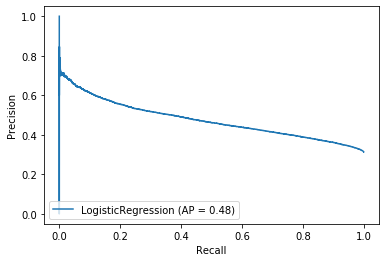

Confusion Matrix
LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='none',
                   random_state=1234, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
[[74609 31467]
 [22505 26040]]
Accuracy:	0.6509400404860918
Precision:	0.4528144399812197
Recall:		0.5364095169430425
F1 Score:	0.49107984762192125

{'criterion': ['entropy'], 'max_depth': [10, 30], 'min_samples_split': [100]}
Running:  DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1234, splitt

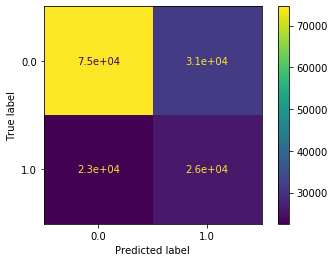

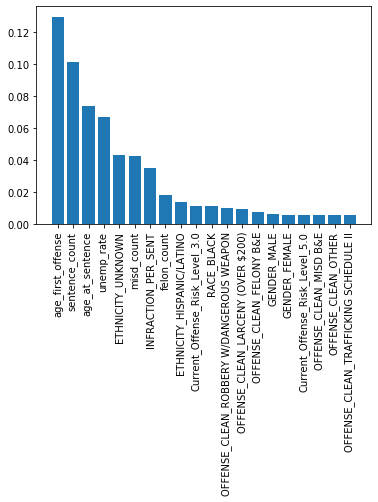

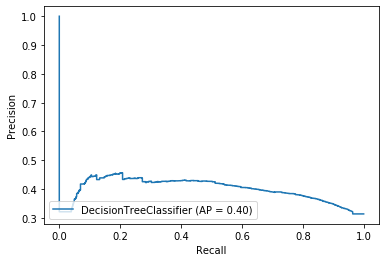

Confusion Matrix
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=30, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=1234, splitter='best')
[[79412 26664]
 [28326 20219]]
Accuracy:	0.6443561999987065
Precision:	0.4312650640957277
Recall:		0.4165001544958286
F1 Score:	0.42375403445529614

{'criterion': ('gini', 'entropy'), 'n_estimators': (100, 1000, 5000), 'max_depth': (10, 20, 30, None), 'min_samples_split': (5, 50, 100)}
Running:  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decreas

In [ ]:
results, best_models = classification.run_classifier(train_data,validate_data,test_data,target_type)

best_models.to_csv('../results/best_models_'+target_type+'_'+features+'.csv', index=False)
results.to_csv('../results/results'+target_type+'_'+features+'.csv', index=False)

In [ ]:
results

In [ ]:
best_models

In [ ]:
# Step 2
target_type = "binary"
features = "No Demographics"

#print(features)
#train_data, test_data, validate_data, active_sentences = build.split_and_process(dataset_1,config,grouping_target)
train_data, test_data, validate_data, active_sentences, active_almost_complete = build.split_and_process(dataset_3,config,target_type,features)

# Sanity Check
print('Train and Test Check:')
build.sanity_check(train_data,test_data)

print('Train and Validate Check:')
build.sanity_check(train_data,validate_data)

print('Train and Active Check:')
build.sanity_check(train_data,active_sentences)

print('Train and Active Almost Complete Check:')
build.sanity_check(train_data,active_almost_complete)



In [ ]:
validate_data.groupby(target).count()


In [ ]:
results, best_models = classification.run_classifier(train_data,validate_data,test_data,target_type)
best_models.to_csv('../results/best_models_'+target_type+'_'+features+'.csv', index=False)
results.to_csv('../results/results'+target_type+'_'+features+'.csv', index=False)


In [ ]:
results

In [ ]:
best_models

In [ ]:
# Step 3
target_type = "three_class"
features = "Demographics"

#print(features)
#train_data, test_data, validate_data, active_sentences = build.split_and_process(dataset_1,config,grouping_target)
train_data, test_data, validate_data, active_sentences, active_almost_complete = build.split_and_process(dataset_3,config,target_type,features)

# Sanity Check
print('Train and Test Check:')
build.sanity_check(train_data,test_data)

print('Train and Validate Check:')
build.sanity_check(train_data,validate_data)

print('Train and Active Check:')
build.sanity_check(train_data,active_sentences)

print('Train and Active Almost Complete Check:')
build.sanity_check(train_data,active_almost_complete)

In [ ]:
validate_data.groupby(target).count()


In [ ]:
# train_data = train_data.sample(10000)
# validate_data = validate_data.sample(5000)
# test_data = test_data.sample(3000)

In [ ]:
results, best_models = classification.run_classifier(train_data,validate_data,test_data,target_type)
best_models.to_csv('../results/best_models_'+target_type+'_'+features+'.csv', index=False)
results.to_csv('../results/results'+target_type+'_'+features+'.csv', index=False)


In [ ]:
results

In [ ]:
best_mdodels

In [ ]:
# Step 3
target_type = "three_class"
features = "No Demographics"

#print(features)
#train_data, test_data, validate_data, active_sentences = build.split_and_process(dataset_1,config,grouping_target)
train_data, test_data, validate_data, active_sentences, active_almost_complete = build.split_and_process(dataset_3,config,target_type,features)

# Sanity Check
print('Train and Test Check:')
build.sanity_check(train_data,test_data)

print('Train and Validate Check:')
build.sanity_check(train_data,validate_data)

print('Train and Active Check:')
build.sanity_check(train_data,active_sentences)

print('Train and Active Almost Complete Check:')
build.sanity_check(train_data,active_almost_complete)

In [ ]:
validate_data.groupby(target).count()


In [ ]:
results, best_models = classification.run_classifier(train_data,validate_data,test_data,target_type)
best_models.to_csv('../results/best_models_'+target_type+'_'+features+'.csv', index=False)
results.to_csv('../results/results'+target_type+'_'+features+'.csv', index=False)


In [ ]:
results

In [ ]:
best_models

In [ ]:
# Step 4
target_type = "all"
features = "Demographics"

#print(features)
#train_data, test_data, validate_data, active_sentences = build.split_and_process(dataset_1,config,grouping_target)
train_data, test_data, validate_data, active_sentences, active_almost_complete = build.split_and_process(dataset_3,config,target_type,features)

# Sanity Check
print('Train and Test Check:')
build.sanity_check(train_data,test_data)

print('Train and Validate Check:')
build.sanity_check(train_data,validate_data)

print('Train and Active Check:')
build.sanity_check(train_data,active_sentences)

print('Train and Active Almost Complete Check:')
build.sanity_check(train_data,active_almost_complete)

In [ ]:
validate_data.groupby(target).count()


In [ ]:
results, best_models = classification.run_classifier(train_data,validate_data,test_data,target_type)
best_models.to_csv('../results/best_models_'+target_type+'_'+features+'.csv', index=False)
results.to_csv('../results/results'+target_type+'_'+features+'.csv', index=False)


In [ ]:
results

In [ ]:
best_models

In [ ]:
# Step 4
target_type = "all"
features = "No Demographics"

#print(features)
#train_data, test_data, validate_data, active_sentences = build.split_and_process(dataset_1,config,grouping_target)
train_data, test_data, validate_data, active_sentences, active_almost_complete = build.split_and_process(dataset_3,config,target_type,features)

# Sanity Check
print('Train and Test Check:')
build.sanity_check(train_data,test_data)

print('Train and Validate Check:')
build.sanity_check(train_data,validate_data)

print('Train and Active Check:')
build.sanity_check(train_data,active_sentences)

print('Train and Active Almost Complete Check:')
build.sanity_check(train_data,active_almost_complete)

In [ ]:
validate_data.groupby(target).count()


In [ ]:
results, best_models = classification.run_classifier(train_data,validate_data,test_data,target_type)
best_models.to_csv('../results/best_models_'+target_type+'_'+features+'.csv', index=False)
results.to_csv('../results/results'+target_type+'_'+features+'.csv', index=False)


In [ ]:
results

In [ ]:
best_models